# TP 4

### Enunciado

Para las imágenes suministradas:
1. Implementar extractor de características LBP básico (sin uniformidad, 8 vecinos)
2. Realizar el histograma de características LBP de la imagen.
3. Comparar los histogramas.

In [1]:
#%matplotlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from os import walk,path


In [2]:
def collect_image_filenames(img_path):
    img_filenames = []
    for (dirpath, dirnames, filenames) in walk(img_path):
        img_filenames.extend(filenames)
        break
    return list(map(lambda x: img_path+x,img_filenames))

In [3]:
IMAGE_PATH = "./data/"
testrgb_img_filenames = collect_image_filenames(img_path=IMAGE_PATH)
testrgb_img_filenames

test_images = []
for i in range(0, len(testrgb_img_filenames)):
    image_filename = testrgb_img_filenames[i]
    print(image_filename)
    img = cv2.imread(image_filename)[...,::-1] # fix colors
    test_images.append(img)    
    #print(img.shape)
    #print("Average Color: ", img[:,:,0].mean(),img[:,:,1].mean(),img[:,:,2].mean())
    #print("Max Color: ", img[:,:,0].max(),img[:,:,1].max(),img[:,:,2].max())

./data/cielo.png
./data/piedras2.png
./data/rbt_scn3_focus.png
./data/rbt_scn2.png
./data/piedras1.png
./data/oveja1.png
./data/rbt_scn4.png
./data/ladrillos1.png
./data/rbt_scn4_focus.png
./data/rbt_scn3.png
./data/oveja2.png
./data/rbt_scn1_focus.png
./data/ladrillos2.png


In [4]:
def lbp(x):
    lbp_code = 0
    visit_list = [(0,0),(0,-1), (1,-1), (1,0),(1,1), (0,1),(-1,1),(-1,0),(-1,-1)]
    for i in range(len(visit_list)-1):
        cell_value = 1 if (x[visit_list[i]]-x[visit_list[i+1]]) >= 0  else 0
        lbp_code |= cell_value << i
    return lbp_code

def get_lbp_texture(x):
    if x.ndim> 2:
        gray = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY).astype(np.float32)
    else:
        gray = x.astype(np.float32)
    lbp_texture = np.zeros( (x.shape[0]-2,x.shape[1]-2) )
    #print(x.shape,lbp_texture.shape)
    for iy in range(1,gray.shape[0]-1):
        for ix in range(1,gray.shape[1]-1):
            lbp_code = lbp(gray[iy-1:iy+2,ix-1:ix+2])
            lbp_texture[iy-1,ix-1] = lbp_code
            #print(lbp_code)
    return lbp_texture.astype(np.uint8)

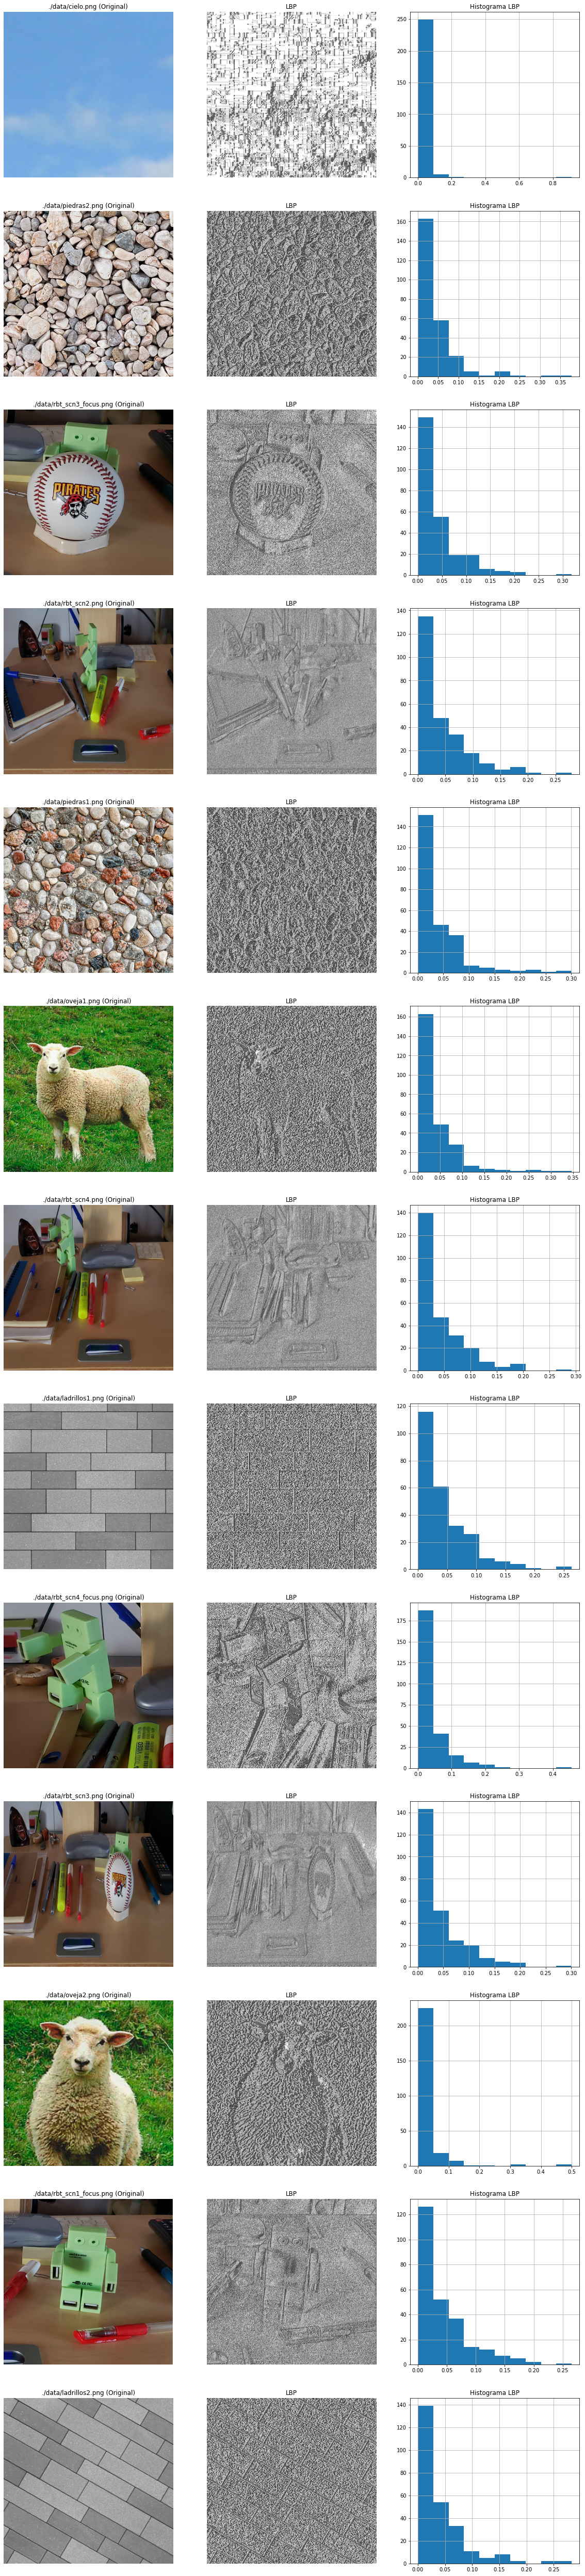

In [5]:
HISTOGRAM_SIZE=256
n_images = len(test_images)
fig, ax = plt.subplots(n_images,3,figsize=(20,7*n_images)) 
histograms = []
for i in range(n_images):
    ax[i][0].set_title(f"{testrgb_img_filenames[i]} (Original)")
    ax[i][0].imshow(test_images[i],aspect='auto')
    ax[i][0].axis('off')
    ax[i][1].set_title("LBP")
    lbp_img = get_lbp_texture(test_images[i])
    ax[i][1].imshow(lbp_img,aspect='auto',cmap='gray', vmin=0, vmax=255)
    ax[i][1].axis('off')
    
    hist = cv2.calcHist([lbp_img],[0],None,[HISTOGRAM_SIZE],[0,256]).ravel()
    hist = cv2.normalize(hist, hist).flatten()
    histograms.append(hist)
    ax[i][2].set_title("Histograma LBP")
    ax[i][2].hist(hist)
    ax[i][2].grid(which="Both")
    
plt.show()

## Comparación de histogramas

Ver: [OpenCV Histograms](https://docs.opencv.org/master/d6/dc7/group__imgproc__hist.html#ga994f53817d621e2e4228fc646342d386)

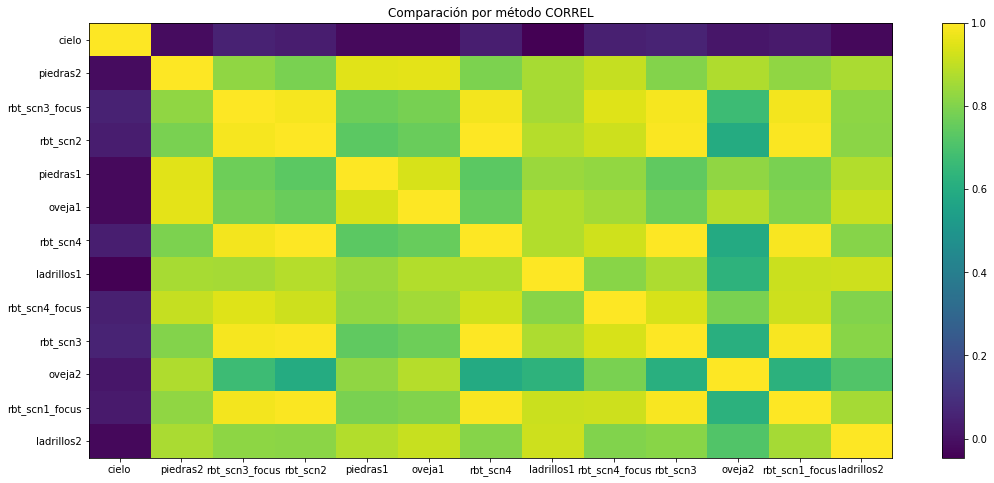

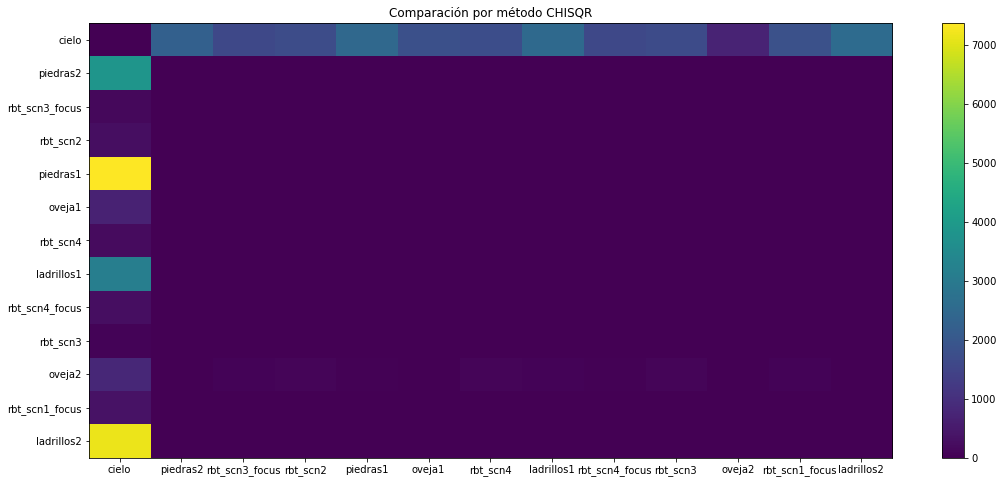

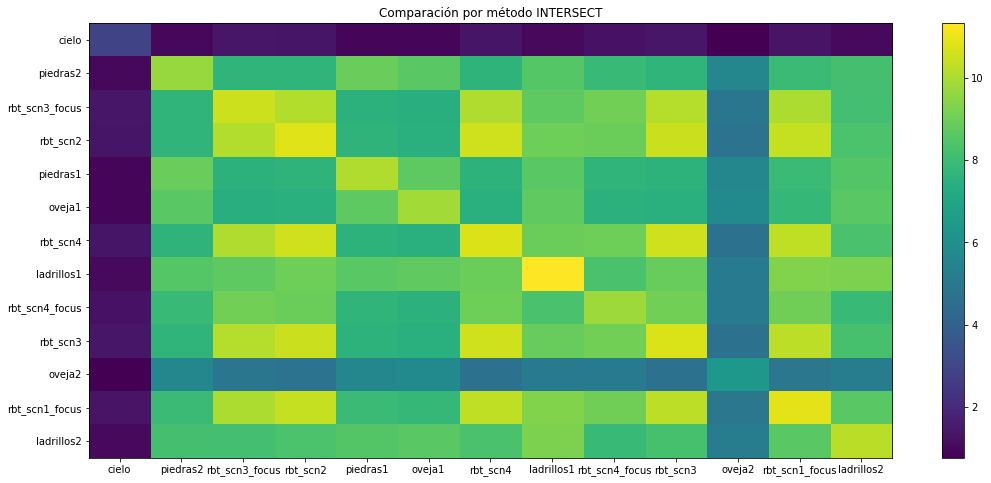

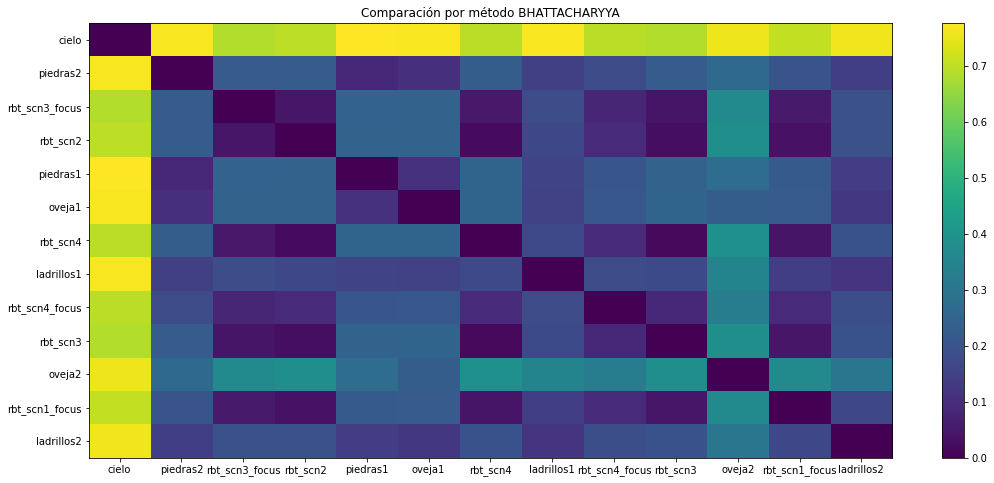

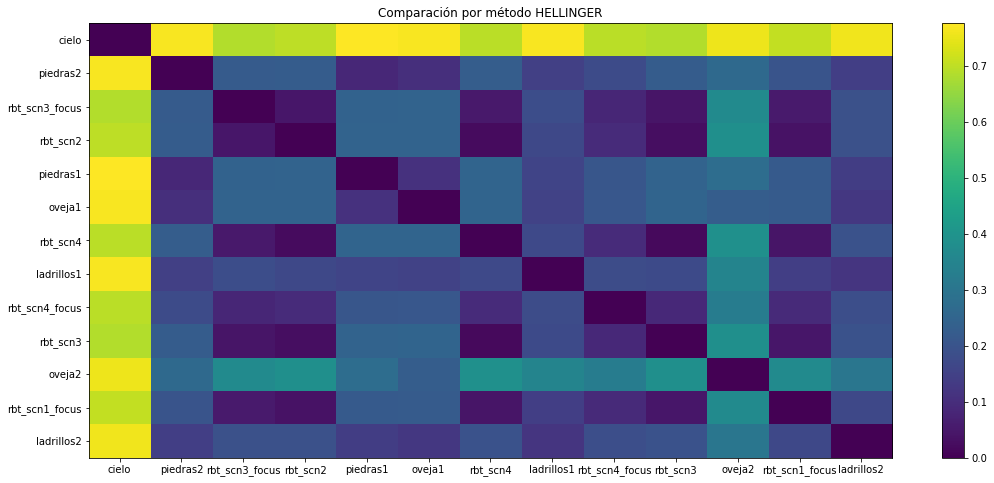

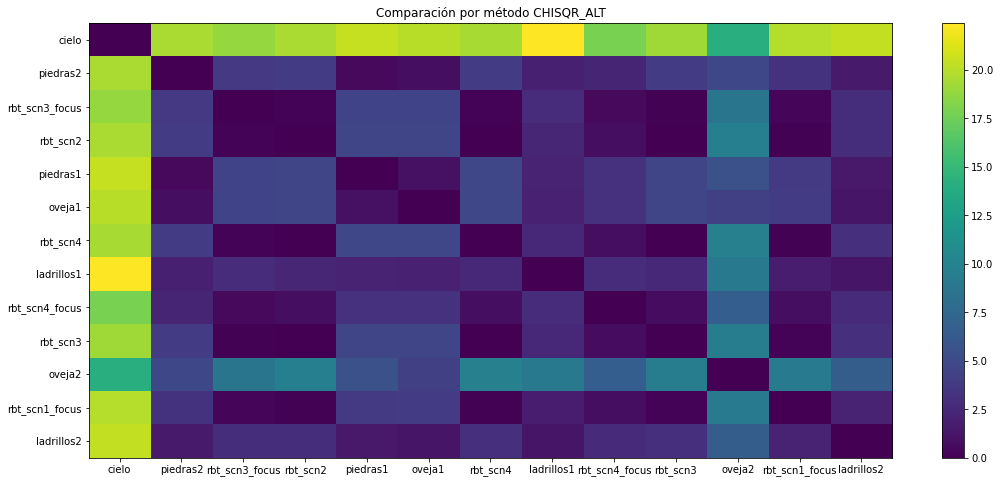

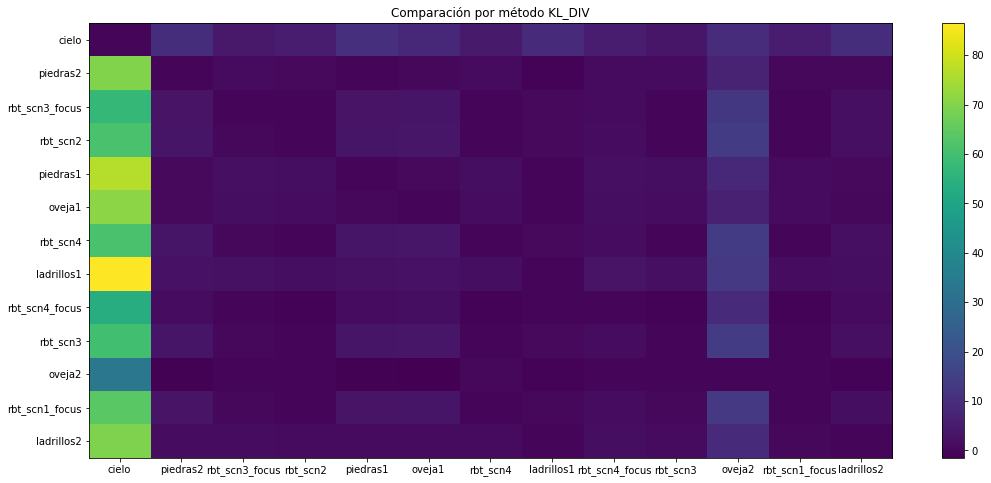

In [39]:
import pandas as pd
from IPython.display import display, HTML

methods = {
    "CORREL":cv2.HISTCMP_CORREL,
    "CHISQR":cv2.HISTCMP_CHISQR,
    "INTERSECT":cv2.HISTCMP_INTERSECT,
    "BHATTACHARYYA":cv2.HISTCMP_BHATTACHARYYA,
    "HELLINGER":cv2.HISTCMP_HELLINGER,
    "CHISQR_ALT":cv2.HISTCMP_CHISQR_ALT,
    "KL_DIV":cv2.HISTCMP_KL_DIV
}

def perform_comparison(method):
    similarity_matrix = np.zeros((n_images,n_images))
    img_labels = []
    for h1 in range(n_images):
        img_labels.append( path.splitext(path.split(testrgb_img_filenames[h1])[1])[0])
        for h2 in range(n_images):
            similarity_matrix[h1,h2] = cv2.compareHist(histograms[h1], histograms[h2], methods[method])
    plt.figure(figsize=(18,8))
    plt.title(f"Comparación por método {method}")
    plt.imshow(similarity_matrix,aspect='auto')
    plt.xticks(np.arange(0,n_images),labels=img_labels)
    plt.yticks(np.arange(0,n_images),labels=img_labels)
    plt.colorbar()
    plt.show()
    return similarity_matrix, img_labels
    

for m in methods:    
    sm,img_labels = perform_comparison(m)
    # Mostrar de más similares a menos similares
    df = pd.DataFrame(sm)
    df.columns =  img_labels
    df.index = img_labels
    display(HTML(df.to_html()))

## Conclusiones

- Para un humano, es relativamente inmediato encontrar similares:
    - Las dos imágenes de los ladrillos.
    - Las dos imágenes de las ovejas.
    - Las imágenes de las escenas del robot
    - Las dos imágenes de las piedras.
- De los métodos de comparación de histograma ensayados los que mejor parecen capturar esta similitud (para los parámetros de histograma elegidos) son:
    - cv2.HISTCMP_CORREL
    - cv2.HISTCMP_INTERSECT
    - cv2.HISTCMP_BHATTACHARYYA
    - cv2.HISTCMP_HELLINGER
    - cv2.HISTCMP_CHISQR_ALT
- No obstante, se observa que para estos algoritmos también son similares escenas que para un observador humano claramente no lo son, como por ejemplo las piedras y las ovejas.    